In [3]:
# Import Libraries
import os
import cv2
import kagglehub
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Load Dataset
DATASET_DIR = "dataset/leapGestRecog"
IMG_SIZE = 64
X = []
y = []

label_map = {}
label_id = 0

# Each subject folder (00, 01, 02...)
for subject in os.listdir(DATASET_DIR):
    subject_path = os.path.join(DATASET_DIR, subject)
    if not os.path.isdir(subject_path):
        continue

    # Each gesture folder inside subject
    for gesture in os.listdir(subject_path):
        gesture_path = os.path.join(subject_path, gesture)
        if not os.path.isdir(gesture_path):
            continue

        if gesture not in label_map.values():
            label_map[label_id] = gesture
            current_label = label_id
            label_id += 1
        else:
            # get existing label
            current_label = list(label_map.keys())[list(label_map.values()).index(gesture)]

        for img_name in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                X.append(img)
                y.append(current_label)

In [7]:
# Convert to numpy
X = np.array(X, dtype="float32") / 255.0
y = np.array(y)

print("Images loaded:", X.shape[0])
print("Labels loaded:", y.shape[0])
print("Classes:", len(label_map))

# Safety check
if len(X) == 0:
    raise ValueError("No images loaded. Check dataset path.")

X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = to_categorical(y)

Images loaded: 20000
Labels loaded: 20000
Classes: 20


In [8]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,866 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train Model
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=32
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - accuracy: 0.6412 - loss: 1.0202 - val_accuracy: 0.9980 - val_loss: 0.0157
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.9764 - loss: 0.0789 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.9860 - loss: 0.0425 - val_accuracy: 0.9992 - val_loss: 0.0027
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.9907 - loss: 0.0296 - val_accuracy: 1.0000 - val_loss: 5.2899e-04
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9939 - loss: 0.0206 - val_accuracy: 1.0000 - val_loss: 1.3994e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9961 - loss: 0.0151 - val_accuracy: 0.9998 - val_loss: 3.0708e-04
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9928 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 1.7715e-04
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9939 -

In [11]:
# Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 2.1016e-04
Test Accuracy: 100.00%


In [12]:
# Save model
model.save("hand_gesture_model.h5")
print("Model saved as hand_gesture_model.h5")

Model saved as hand_gesture_model.h5


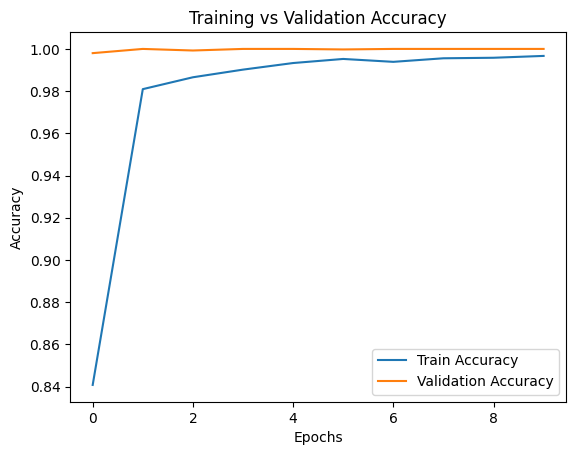

In [13]:
# visualization
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [16]:
def predict_gesture(img_path, model, IMG_SIZE=64, label_map=label_map):
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Image not found:", img_path)
        return None
    
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    
    pred = model.predict(img)
    pred_class = np.argmax(pred, axis=1)[0]
    
    gesture_name = label_map.get(pred_class, "Unknown")
    return gesture_name

# Example usage:
new_image_path = "path_to_new_image1.jpg"  # replace with your image path
predicted_gesture = predict_gesture(new_image_path, model)
print("Predicted Gesture:", predicted_gesture)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Gesture: 07_ok
